In [1]:
using ValkyrieLCMSim
using RigidBodySim
using ValkyrieRobot
using RigidBodyDynamics.Contact

In [2]:
valkyrie = Valkyrie()
mechanism = valkyrie.mechanism
remove_fixed_tree_joints!(mechanism);

In [3]:
feet = Dict(:left => findbody(mechanism, "leftFoot"), :right => findbody(mechanism, "rightFoot"))
hands = Dict(:left => findbody(mechanism, "leftPalm"), :right => findbody(mechanism, "rightPalm"))
controller = LCMController(HumanoidRobotInfo(mechanism, feet, hands));

In [4]:
state = MechanismState(mechanism)
rand!(state)
τ = zeros(num_velocities(state))
t = rand()
controller(τ, t, state)

36-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [15]:
using BenchmarkTools

In [17]:
@benchmark $controller($τ, $t, $state)

BenchmarkTools.Trial: 
  memory estimate:  6.94 KiB
  allocs estimate:  159
  --------------
  minimum time:     21.998 μs (0.00% GC)
  median time:      24.291 μs (0.00% GC)
  mean time:        25.474 μs (3.53% GC)
  maximum time:     3.121 ms (97.53% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [18]:
function testfunc(controller, τ, t, state, n)
    for i = 1 : n
        controller(τ, t, state)
    end
end

testfunc (generic function with 1 method)

In [25]:
testfunc(controller, τ, t, state, 1)
Profile.clear_malloc_data()
@profile testfunc(controller, τ, t, state, 100000)

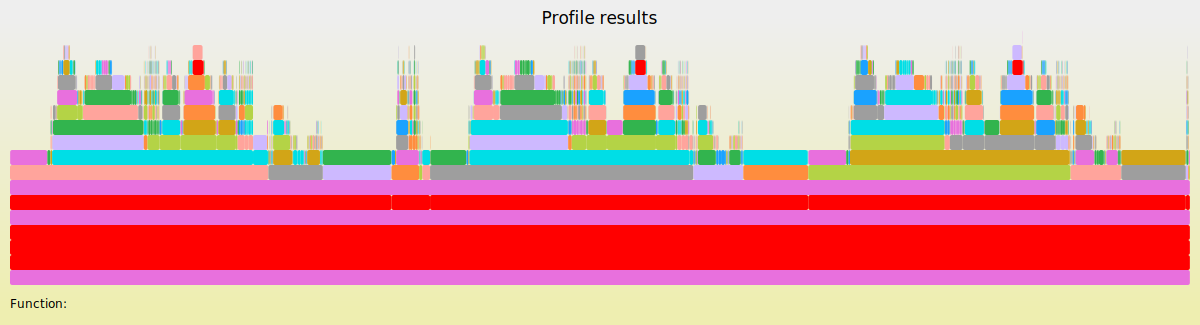

In [26]:
using ProfileView
ProfileView.view()